
# Perpetuals Simulation Notebook

This notebook provides a **clean, modular** simulation framework for perpetual futures (perps) to accompany a theoretical paper.  
It focuses on: (i) a flexible price-path generator, (ii) perp mechanics (fees, funding, liquidation), (iii) single-path and batch simulations, (iv) sensitivity studies and visualizations.

> **Design goals:** transparency, reproducibility, and ease of extension for protocol-specific rules.



## Contents
1. [Setup](#setup)  
2. [Price Processes](#price)  
3. [Perp Mechanics](#mechanics)  
4. [Single-Path Simulation](#single)  
5. [Batch Simulation & Metrics](#batch)  
6. [Sensitivity Studies (Leverage, Volatility, Fees)](#sensitivity)  
   - 6.1 Liquidation Probability (%) heatmap  
   - 6.2 Median Realized PnL heatmap  
7. [Protocol-Style Presets (Example)](#presets)  



<a id='setup'></a>

## 1) Setup


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, Dict, Any, Tuple, List

# Reproducibility
np.random.seed(42)

# Display options
pd.set_option("display.precision", 6)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)



<a id='price'></a>

## 2) Price Processes

We model the underlying price asset with a discrete-time exact solution of the continuous-time GBM SDE $dS_t = \mu S_t\,dt + \sigma S_t\,dW_t$.
On a uniform grid with step $\Delta t$, the update is

$$
S_{t+\Delta t}
= S_t \,\exp\!\Big( (\mu - \tfrac{1}{2}\sigma^2)\,\Delta t \;+\; \sigma\sqrt{\Delta t}\,\varepsilon_t \Big),
\qquad \varepsilon_t \sim \mathcal{N}(0,1)\ \text{i.i.d.}
$$

**Elements and units (as used in this notebook):**

* $S_t$: spot price at time $t$ (in quote currency).
* $S_{t+\Delta t}$: next-step spot price.
* $\Delta t$: time step; we measure **in days** (e.g., $\Delta t = 1/24$ for hourly steps).
* $\mu$: drift per day under the chosen measure (real-world or risk-neutral).
  • Risk-neutral note: with continuous rate $r$ and dividend/yield $q$, replace $\mu$ by $r - q$ (or set $\mu = 0$ if prices are already discounted).
* $\sigma$: volatility per $\sqrt{\text{day}}$.
* $\varepsilon_t$: i.i.d. standard Normal shocks, $\varepsilon_t \overset{\text{i.i.d.}}{\sim} \mathcal{N}(0,1)$, independent across time. The factor $\sqrt{\Delta t}$ ensures that variance scales linearly with elapsed time.

**Deterministic vs. random parts:**

* **Drift term** $(\mu - \tfrac{1}{2}\sigma^2)\Delta t$: includes the **Itô/Jensen correction** $-\tfrac{1}{2}\sigma^2$ 
* **Diffusion term** $\sigma\sqrt{\Delta t}\,\varepsilon_t$: the random innovation.





In [2]:
@dataclass
class PriceProcessParams:
    S0: float = 100.0      # initial spot price
    mu: float = 0.0        # drift per day
    sigma: float = 0.5     # volatility per sqrt(day)
    T: float = 7.0         # time horizon in days
    dt: float = 1/24       # step size in days (hourly)

def generate_price_path(p: PriceProcessParams, rng: np.random.Generator | None = None) -> pd.DataFrame:
    """
    Geometric Brownian Motion (GBM), exact step:
      S_{t+Δt} = S_t * exp( (μ - 0.5 σ^2) Δt + σ √Δt ε_t ),  ε_t ~ N(0,1)

    Returns a DataFrame with columns:
      - t (days)  : [0, dt, ..., T]
      - S (price) : simulated spot
    """
    if rng is None:
        rng = np.random.default_rng()

    n_steps = int(np.round(p.T / p.dt))
    times = np.linspace(0.0, p.T, n_steps + 1)

    S = np.empty(n_steps + 1, dtype=float)
    S[0] = p.S0

    drift = (p.mu - 0.5 * p.sigma**2) * p.dt
    scale = p.sigma * np.sqrt(p.dt)

    for t in range(n_steps):
        z = rng.standard_normal()
        S[t + 1] = S[t] * np.exp(drift + scale * z)

    return pd.DataFrame({"t": times, "S": S})


<a id='mechanics'></a>

## 3) Perp Mechanics

We assume a **cross-margined** perp position with:
- **Collateral** $C$ and **leverage** $L$ → notional $N = L\cdot C$.
- **Trading fees** on open and close at rate $f_{\text{trade}}$ times notional.
- **Borrow fee** accruing at rate $f_{\text{borrow}}$ on notional per unit time (scaled by $\Delta t$).
- **Funding payments** based on a funding rate process $r^{\text{fund}}_t$. By default, we model a simple premium-to-EMA proxy.
- **Maintenance margin rate** $m_{\mathrm{maint}}$; liquidation occurs when the **margin ratio** $\mathrm{MR}_t = \frac{\text{Equity}_t}{N_t}$ falls below $m_{\mathrm{maint}}$.

**Equity** at time $t$:
$
\text{Equity}_t = C + \text{UPnL}_t - (\text{Fees}^{\text{open}} + \text{Fees}^{\text{borrow}}_{\le t} + \text{Fees}^{\text{fund}}_{\le t}),
$
with unrealized PnL $\text{UPnL}_t$ computed from the mark $S_t$ relative to entry $S_0$.


In [3]:
@dataclass
class PerpParams:
    is_long: bool = True
    collateral: float = 1000.0
    leverage: float = 10.0
    trading_fee_rate: float = 0.0006   # per open/close on notional
    borrow_fee_rate: float = 0.000027  # per unit time (same time unit as dt)
    maintenance_margin_rate: float = 0.005
    slippage_bps_open: float = 0.0     # applied once at entry as additional fee on notional
    slippage_bps_close: float = 0.0    # optional
    apply_funding_fee: bool = False
    funding_kappa: float = 0.0         # strength of funding vs premium proxy
    funding_ema_span: int = 24         # EMA span (steps) for premium proxy


def ema(series: np.ndarray, span: int) -> np.ndarray:

    """
    Compute the Exponential Moving Average (EMA) of a 1-D array using the 'span' parameter.
    Recurrence:
        y[i] = alpha * x[i] + (1 - alpha) * y[i-1]
    with alpha = 2 / (span + 1), matching pandas' ewm(span=..., adjust=False).
    """
    # Ensure we have a float NumPy array (stable math, avoids dtype surprises)
    series = np.asarray(series, dtype=float)
        
    # Degenerate case: with span <= 1, smoothing disappears (alpha = 1).
    # Return a copy so callers can safely modify the result.
    if span <= 1:
        return series.copy()

    # Convert 'span' to the smoothing factor alpha in (0, 1].
    # Larger span -> smaller alpha -> smoother (slower-reacting) EMA.
    alpha = 2.0 / (span + 1.0)

    # Preallocate output array (same shape and dtype as input)
    y = np.empty_like(series, dtype=float)

    # Initialize EMA with the first observation (simple, standard choice)
    y[0] = series[0]

    # Micro-optimization: compute once and reuse
    one_minus_alpha = 1.0 - alpha

    # Recursive EMA update:
    # each new EMA is a blend of the current value (weight = alpha)
    # and the previous EMA (weight = 1 - alpha).
    for i in range(1, len(series)):
        y[i] = alpha * series[i] + one_minus_alpha * y[i - 1]

    # Return the full EMA path (same length as input)
    return y


def simulate_perp_single(price_df: pd.DataFrame, perp: PerpParams) -> Dict[str, Any]:
    # --- 1) Unpack the input price path and build a time-step vector ---
    S = price_df["S"].values                  # price path S_0, S_1, ..., S_T
    t = price_df["t"].values                  # time grid in *days*
    dt = np.diff(t, prepend=t[0])             # per-step elapsed time Δt_i (same units as t)
    dt[0] = dt[1] if len(dt) > 1 else dt[0]   # guard: avoid a zero first step

    # --- 2) Position sizing at entry ---
    S0 = S[0]                                 # entry price (mark at t=0)
    notional = perp.leverage * perp.collateral  # entry notional N = L * C
    q = (notional / S0) * (1.0 if perp.is_long else -1.0)  # position size in units of the asset

    # --- 3) One-off fees paid at open (charged on notional) ---
    open_trading_fee = perp.trading_fee_rate * abs(notional)          # % fee on notional
    open_slippage_fee = (perp.slippage_bps_open/1e4) * abs(notional)  # bps -> rate
    fees_open = open_trading_fee + open_slippage_fee                   # stored and subtracted every step via total_fees

    # --- 4) Funding setup (EMA-based proxy). If disabled, zeros. ---
    if perp.apply_funding_fee and perp.funding_kappa != 0.0:
        ema_S = ema(S, span=perp.funding_ema_span)                     # smooth "anchor"
        premium = (S - ema_S) / np.maximum(ema_S, 1e-12)               # dimensionless premium S/EMA - 1
        funding_rate_path = perp.funding_kappa * premium               # r_fund_t (per day)
    else:
        funding_rate_path = np.zeros_like(S)

    # --- 5) Allocate outputs and running totals ---
    equity = np.empty_like(S, dtype=float)   # Equity_t path
    upnl = np.empty_like(S, dtype=float)     # Unrealized PnL_t path
    cum_funding_fee = 0.0                    # cumulative funding paid(+) / received(-)
    cum_borrow_fee = 0.0                     # cumulative borrow fee paid

    liquidated = False                       # liquidation flag
    liq_index = -1                           # index of liquidation time (if any)

    # --- 6) Main loop over time steps ---
    for i in range(len(S)):
        price_now = S[i]
        upnl[i] = q * (price_now - S0)       # mark-to-market PnL vs entry

        if i > 0:
            # Borrow fee accrues on *entry notional* each step (units consistent with dt)
            cum_borrow_fee += perp.borrow_fee_rate * abs(notional) * dt[i]
            # Funding cash flow: sign(q) decides who pays; accrual on *entry notional*
            # Positive funding_rate -> longs pay, shorts receive.
            cum_funding_fee += (np.sign(q) * abs(notional) * funding_rate_path[i] * dt[i])

        # Total fees to date: open (once) + borrow (cum) + funding (cum)
        total_fees = fees_open + cum_borrow_fee + cum_funding_fee

        # Equity_t = collateral + UPnL_t - cumulative fees
        equity[i] = perp.collateral + upnl[i] - total_fees

        # --- 7) Liquidation check via margin ratio ---
        notional_now = abs(q) * price_now                 # current mark notional
        mr = equity[i] / max(notional_now, 1e-12)         # margin ratio MR_t

        if (not liquidated) and (mr <= perp.maintenance_margin_rate):
            # Trigger liquidation: close at current price and charge closing costs once
            liquidated = True
            liq_index = i
            close_fee = perp.trading_fee_rate * notional_now + (perp.slippage_bps_close/1e4) * notional_now
            equity[i] -= close_fee

            # Absorbing state after liquidation: hold equity and PnL flat for the rest of the path
            equity[i:] = equity[i]
            upnl[i:] = upnl[i]
            break

    # --- 8) If we survive to maturity, charge closing costs at the end ---
    if not liquidated:
        notional_end = abs(q) * S[-1]
        close_fee = perp.trading_fee_rate * notional_end + (perp.slippage_bps_close/1e4) * notional_end
        equity[-1] -= close_fee

    # --- 9) Package results for downstream use/plots ---
    out = {
        "equity_path": equity,
        "upnl_path": upnl,
        "funding_rate_path": funding_rate_path,
        "price_path": S,
        "time": t,
        "liquidated": liquidated,
        "liq_index": liq_index,
        "final_equity": float(equity[-1]),
        "final_upnl": float(upnl[-1]),
        "fees_open": float(fees_open),
        "cum_borrow_fee": float(cum_borrow_fee),
        "cum_funding_fee": float(cum_funding_fee),
    }
    return out


<a id='single'></a>

## 4) Single-Path Simulation

Use `PriceProcessParams` and `PerpParams` to define the market and position.  
The helper below runs one scenario and draws (i) price & equity paths and (ii) fee breakdown at the end.


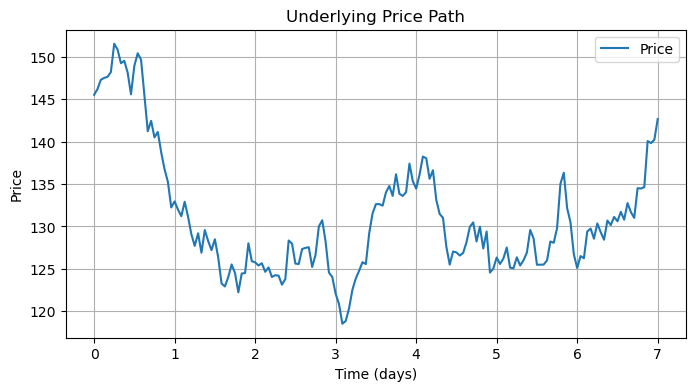

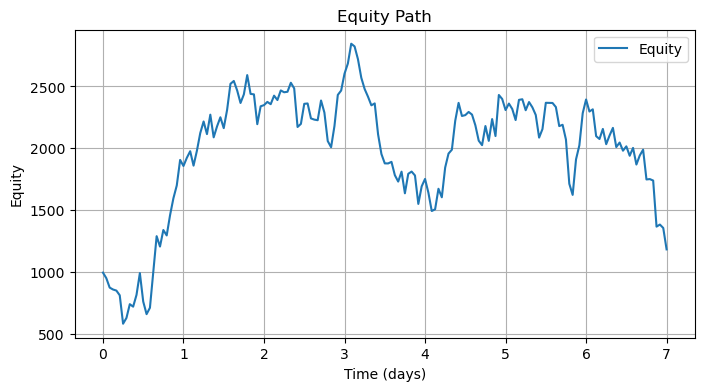

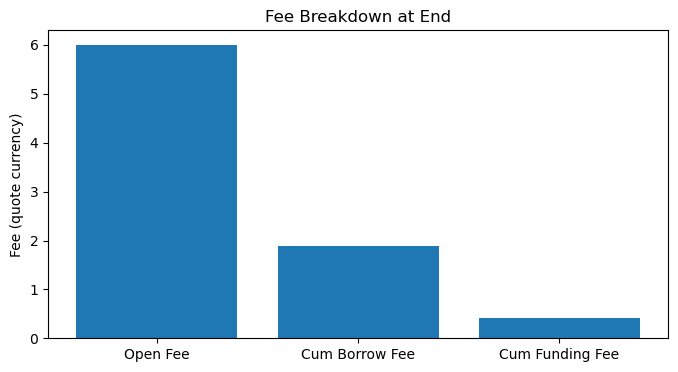

In [51]:
def run_single_demo(
    price_params: PriceProcessParams = PriceProcessParams(S0=145.51, mu=0.0, sigma=0.08, T=7, dt=1/24,),
    perp_params: PerpParams = PerpParams(is_long=False, collateral=1000.0, leverage=10.0, 
                                         trading_fee_rate=0.0006, borrow_fee_rate=0.000027,
                                         maintenance_margin_rate=0.002556, funding_kappa=0.001, apply_funding_fee=True)
) -> Dict[str, Any]:
    np.random.seed(42)

    price_df = generate_price_path(price_params)
    res = simulate_perp_single(price_df, perp_params)

    # Plot price
    fig1 = plt.figure(figsize=(8, 4))
    ax = plt.gca()
    ax.plot(res["time"], res["price_path"], label="Price")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Price")
    ax.set_title("Underlying Price Path")
    ax.grid(True)
    ax.legend()
    plt.show()

    # Plot equity
    fig2 = plt.figure(figsize=(8, 4))
    ax2 = plt.gca()
    ax2.plot(res["time"], res["equity_path"], label="Equity")
    ax2.set_xlabel("Time (days)")
    ax2.set_ylabel("Equity")
    ax2.set_title("Equity Path")
    ax2.grid(True)
    ax2.legend()
    plt.show()

    # Fee breakdown at end
    fig3 = plt.figure(figsize=(8, 4))
    ax3 = plt.gca()
    fees_dict = {
        "Open Fee": res["fees_open"],
        "Cum Borrow Fee": res["cum_borrow_fee"],
        "Cum Funding Fee": res["cum_funding_fee"],
    }
    ax3.bar(list(fees_dict.keys()), list(fees_dict.values()))
    ax3.set_title("Fee Breakdown at End")
    ax3.set_ylabel("Fee (quote currency)")
    plt.show()

    return {"price_df": price_df, "result": res}

# Quick demo run (can be commented if not needed)
_ = run_single_demo()


In [52]:
def plot_price_equity_combo(res, title="Asset Price vs. Equity"):
    """
    res: dict ritornato da simulate_perp_single, deve contenere:
         - "time": array-like
         - "price_path": array-like
         - "equity_path": array-like
         opzionale:
         - "liq_time": float (giorni) se calcolato nella simulazione
    """
    t = res["time"]
    price = res["price_path"]
    equity = res["equity_path"]
    liq_time = res.get("liq_time", None)

    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Asset price (blu)
    ax1.set_xlabel("Time (days)")
    ax1.set_ylabel("Price", color="tab:blue")
    line1, = ax1.plot(t, price, color="tab:blue", label="Asset Price")
    ax1.tick_params(axis='y', labelcolor="tab:blue")

    # Equity (rosso)
    ax2 = ax1.twinx()
    ax2.set_ylabel("Equity (USD)", color="tab:red")
    line2, = ax2.plot(t, equity, color="tab:red", label="Equity Path")
    ax2.tick_params(axis='y', labelcolor="tab:red")

    # Linea liquidazione (se presente)
    if liq_time is not None:
        ax1.axvline(x=liq_time, linestyle="--", color="black", label="Liquidation")
        ax2.axvline(x=liq_time, linestyle="--", color="black")

    # Legenda combinata
    lines = [line1, line2]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc="best")

    plt.title(title if title else "Asset Price vs. Equity")
    fig.tight_layout()
    plt.show()


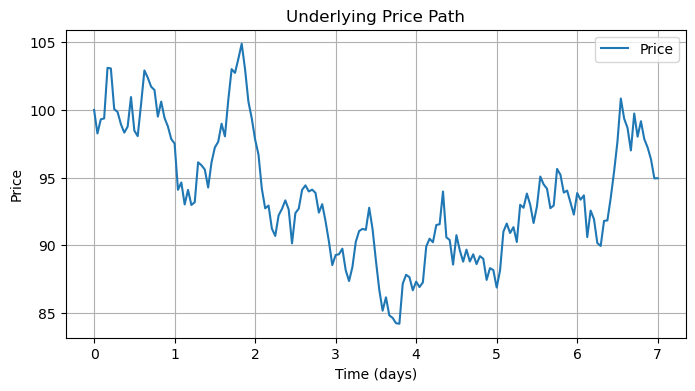

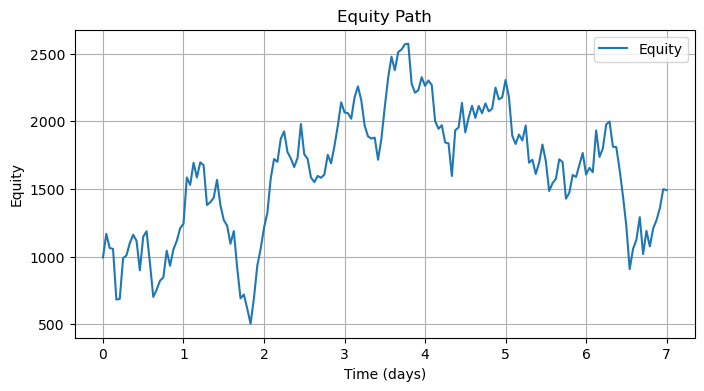

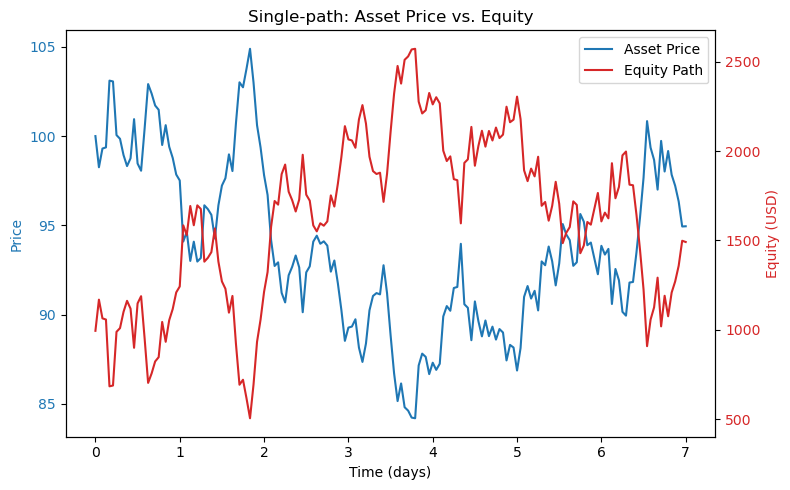

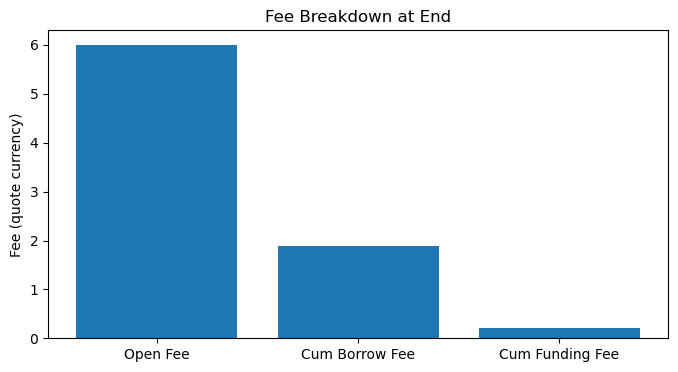

In [54]:
def run_single_demo(
    
    price_params: PriceProcessParams = PriceProcessParams(S0=100, mu=0.0, sigma=0.08, T=7, dt=1/24),
    perp_params: PerpParams = PerpParams(is_long=False, collateral=1000.0, leverage=10.0, 
                                         trading_fee_rate=0.0006, borrow_fee_rate=0.000027,
                                         maintenance_margin_rate=0.002556, funding_kappa=0.001, apply_funding_fee=True)
) -> Dict[str, Any]:

    # 1) genera prezzo e simula
    price_df = generate_price_path(price_params)
    res = simulate_perp_single(price_df, perp_params)

    # 2) plot UNDERLYING price (come avevi)
    fig1 = plt.figure(figsize=(8, 4))
    ax = plt.gca()
    ax.plot(res["time"], res["price_path"], label="Price")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Price")
    ax.set_title("Underlying Price Path")
    ax.grid(True)
    ax.legend()
    plt.show()

    # 3) plot EQUITY (come avevi)
    fig2 = plt.figure(figsize=(8, 4))
    ax2 = plt.gca()
    ax2.plot(res["time"], res["equity_path"], label="Equity")
    ax2.set_xlabel("Time (days)")
    ax2.set_ylabel("Equity")
    ax2.set_title("Equity Path")
    ax2.grid(True)
    ax2.legend()
    plt.show()

    # 4) NUOVO: plot COMBINATO (prezzo + equity + liquidazione se presente)
    plot_price_equity_combo(
        res,
        title="Single-path: Asset Price vs. Equity"
    )

    # 5) breakdown FEES (come avevi)
    fig3 = plt.figure(figsize=(8, 4))
    ax3 = plt.gca()
    fees_dict = {
        "Open Fee": res["fees_open"],
        "Cum Borrow Fee": res["cum_borrow_fee"],
        "Cum Funding Fee": res["cum_funding_fee"],
    }
    ax3.bar(list(fees_dict.keys()), list(fees_dict.values()))
    ax3.set_title("Fee Breakdown at End")
    ax3.set_ylabel("Fee (quote currency)")
    plt.show()

    return {"price_df": price_df, "result": res}

# Quick demo run (puoi commentare)
_ = run_single_demo()



<a id='batch'></a>

## 5) Batch Simulation & Metrics

We now simulate many paths to obtain distributions for **final equity**, **realized PnL**, and **liquidation probability**.


Runs: 2000
Average PnL: 17.26
Liquidation probability: 31.20%


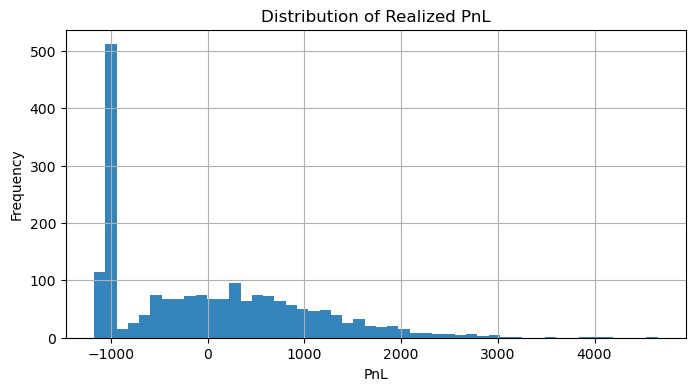

In [5]:
def simulate_batch(n_runs: int, price_params: PriceProcessParams, perp_params: PerpParams, 
                   capture_paths: bool=False) -> Dict[str, Any]:
    finals = []
    liqs = []
    records: List[Dict[str, Any]] = []
    paths_equity = []
    for _ in range(n_runs):
        price_df = generate_price_path(price_params)
        res = simulate_perp_single(price_df, perp_params)
        finals.append(res["final_equity"] - perp_params.collateral)  # realized PnL after close/liq
        liqs.append(res["liquidated"])
        records.append({
            "final_equity": res["final_equity"],
            "realized_pnl": res["final_equity"] - perp_params.collateral,
            "liquidated": res["liquidated"]
        })
        if capture_paths:
            paths_equity.append(res["equity_path"])

    df = pd.DataFrame(records)
    return {
        "df": df,
        "avg_pnl": float(np.mean(finals)),
        "liq_prob": float(np.mean(liqs)),
        "paths_equity": paths_equity
    }

def plot_pnl_distribution(df: pd.DataFrame):
    plt.figure(figsize=(8, 4))
    plt.hist(df["realized_pnl"], bins=50, alpha=0.9)
    plt.title("Distribution of Realized PnL")
    plt.xlabel("PnL")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# Example batch run
batch_out = simulate_batch(
    n_runs=2000,
    price_params=PriceProcessParams(S0=145.51, mu=0.0, sigma=0.04, T=7, dt=1/24),
    perp_params=PerpParams(is_long=True, collateral=1000.0, leverage=10.0, 
                           trading_fee_rate=0.0006, borrow_fee_rate=0.000027, 
                           maintenance_margin_rate=0.002556, apply_funding_fee=False)
)
print(f"Runs: {len(batch_out['df'])}")
print(f"Average PnL: {batch_out['avg_pnl']:.2f}")
print(f"Liquidation probability: {batch_out['liq_prob']*100:.2f}%")
plot_pnl_distribution(batch_out["df"])

# Save results as CSV for paper appendix if useful
#batch_out["df"].to_csv("/mnt/data/perps_batch_results.csv", index=False)



<a id='sensitivity'></a>

## 6) Sensitivity Studies (Leverage, Volatility, Fees)

We explore how risk and performance evolve as we vary parameters.  
First, we provide **Liquidation Probability (%)** across (σ, leverage). Second, we add a **Median Realized PnL** heatmap to avoid VaR/ES concepts while still centering on PnL.


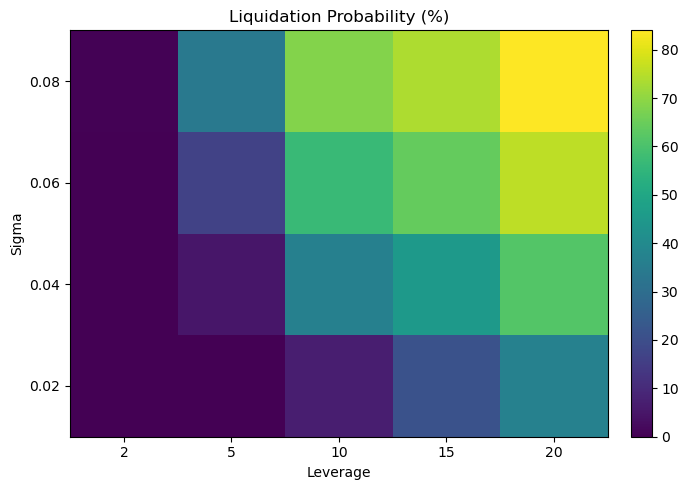

In [6]:
def leverage_sweep(leverage_list: List[float], n_runs: int,
                   price_params: PriceProcessParams, base_perp: PerpParams) -> pd.DataFrame:
    rows = []
    for L in leverage_list:
        perp = PerpParams(**{**base_perp.__dict__, "leverage": L})
        out = simulate_batch(n_runs=n_runs, price_params=price_params, perp_params=perp)
        rows.append({
            "leverage": L,
            "avg_pnl": out["avg_pnl"],
            "liq_prob": out["liq_prob"]
        })
    return pd.DataFrame(rows)

def plot_leverage_sweep(df: pd.DataFrame):
    fig = plt.figure(figsize=(8,4))
    ax = plt.gca()
    ax.plot(df["leverage"], df["avg_pnl"], marker="o", label="Average PnL")
    ax.set_xlabel("Leverage")
    ax.set_ylabel("Average PnL")
    ax.grid(True)
    ax.legend()
    plt.show()

    fig2 = plt.figure(figsize=(8,4))
    ax2 = plt.gca()
    ax2.plot(df["leverage"], 100*df["liq_prob"], marker="o", label="Liquidation Probability (%)")
    ax2.set_xlabel("Leverage")
    ax2.set_ylabel("Liquidation Probability (%)")
    ax2.grid(True)
    ax2.legend()
    plt.show()

# Base grids
price_p = PriceProcessParams(S0=145.51, mu=0.0, sigma=0.04, T=7, dt=1/24)
perp_base = PerpParams(is_long=True, collateral=1000.0, leverage=10.0, 
                       trading_fee_rate=0.0006, borrow_fee_rate=0.000027, 
                       maintenance_margin_rate=0.002556, apply_funding_fee=False)

# 6.1) Liquidation Probability (%) heatmap
def heatmap_liq_prob(leverage_list: List[float], sigma_list: List[float], n_runs: int,
                     base_price: PriceProcessParams, base_perp: PerpParams) -> Tuple[np.ndarray, List[float], List[float]]:
    H = np.zeros((len(sigma_list), len(leverage_list)))
    for i, sig in enumerate(sigma_list):
        for j, L in enumerate(leverage_list):
            price_p = PriceProcessParams(**{**base_price.__dict__, "sigma": sig})
            perp_p = PerpParams(**{**base_perp.__dict__, "leverage": L})
            out = simulate_batch(n_runs=n_runs, price_params=price_p, perp_params=perp_p)
            H[i, j] = out["liq_prob"]
    return H, sigma_list, leverage_list

def plot_heatmap(matrix: np.ndarray, y_ticks: List[float], x_ticks: List[float], title: str, xlabel: str, ylabel: str):
    plt.figure(figsize=(7,5))
    im = plt.imshow(matrix, aspect="auto", origin="lower")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(x_ticks)), x_ticks)
    plt.yticks(range(len(y_ticks)), y_ticks)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

sigma_grid = [0.02, 0.04, 0.06, 0.08]
lev_grid = [2, 5, 10, 15, 20]
H_liq, yy, xx = heatmap_liq_prob(lev_grid, sigma_grid, n_runs=200, base_price=price_p, base_perp=perp_base)
plot_heatmap(100*H_liq, yy, xx, title="Liquidation Probability (%)", xlabel="Leverage", ylabel="Sigma")



### 6.2) Median Realized PnL Heatmap

We now build a PnL-centric heatmap. 
At each grid point, we compute the **median** of the realized PnL distribution across simulated paths.


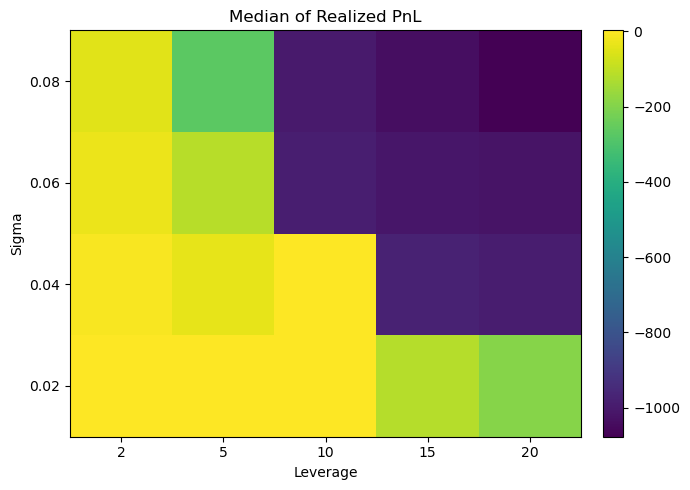

In [ ]:
from typing import Callable

def heatmap_statistic_over_pnl(
    leverage_list: List[float],
    sigma_list: List[float],
    n_runs: int,
    base_price: PriceProcessParams,
    base_perp: PerpParams,
    stat_fn: Callable[[np.ndarray], float],
    stat_name: str = "Statistic"
) -> Tuple[np.ndarray, List[float], List[float]]:
    """Build a heatmap of a PnL-based statistic over (sigma, leverage)."""
    H = np.zeros((len(sigma_list), len(leverage_list)))
    for i, sig in enumerate(sigma_list):
        for j, L in enumerate(leverage_list):
            price_p = PriceProcessParams(**{**base_price.__dict__, "sigma": sig})
            perp_p  = PerpParams(**{**base_perp.__dict__, "leverage": L})
            out = simulate_batch(n_runs=n_runs, price_params=price_p, perp_params=perp_p)
            realized = out["df"]["realized_pnl"].values
            H[i, j] = stat_fn(realized)
    return H, sigma_list, leverage_list

# Build and plot Median PnL heatmap
H_median, yy_median, xx_median = heatmap_statistic_over_pnl(
    leverage_list=lev_grid,
    sigma_list=sigma_grid,
    n_runs=200,
    base_price=price_p,
    base_perp=perp_base,
    stat_fn=np.median,
    stat_name="Median Realized PnL"
)
plot_heatmap(H_median, yy_median, xx_median, title="Median of Realized PnL", xlabel="Leverage", ylabel="Sigma")



**Optional.** To switch to **Mean Realized PnL**, replace `np.median` with `np.mean` in the previous cell or run:
```python
H_mean, yy_mean, xx_mean = heatmap_statistic_over_pnl(
    leverage_list=lev_grid,
    sigma_list=sigma_grid,
    n_runs=200,
    base_price=price_p,
    base_perp=perp_base,
    stat_fn=np.mean,
    stat_name="Mean Realized PnL"
)
plot_heatmap(H_mean, yy_mean, xx_mean, title="Mean of Realized PnL", xlabel="Leverage", ylabel="Sigma")
```


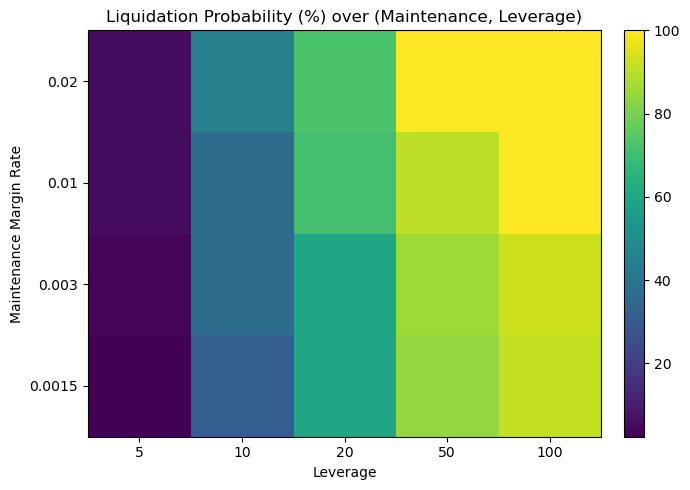

In [8]:
def heatmap_liq_prob_mmr_leverage(
    mmr_list: List[float],
    leverage_list: List[float],
    n_runs: int,
    base_price: PriceProcessParams,
    base_perp: PerpParams,
) -> np.ndarray:
    """
    Matrix H with shape (len(mmr_list), len(leverage_list)):
    H[i, j] = liquidation probability at maintenance_margin_rate = mmr_list[i], leverage = leverage_list[j].
    """
    H = np.zeros((len(mmr_list), len(leverage_list)))
    for i, mmr in enumerate(mmr_list):
        for j, L in enumerate(leverage_list):
            price_p = PriceProcessParams(**{**base_price.__dict__})
            perp_p  = PerpParams(**{**base_perp.__dict__, "maintenance_margin_rate": mmr, "leverage": L})
            out = simulate_batch(n_runs=n_runs, price_params=price_p, perp_params=perp_p)
            H[i, j] = out["liq_prob"]
    return H

def heatmap_stat_over_pnl_mmr_leverage(
    mmr_list: List[float],
    leverage_list: List[float],
    n_runs: int,
    base_price: PriceProcessParams,
    base_perp: PerpParams,
    stat_fn=np.median,  # use np.mean if you prefer
) -> np.ndarray:
    """
    Matrix H with PnL-based statistic over (maintenance margin, leverage).
    Default statistic is the median of realized PnL.
    """
    H = np.zeros((len(mmr_list), len(leverage_list)))
    for i, mmr in enumerate(mmr_list):
        for j, L in enumerate(leverage_list):
            price_p = PriceProcessParams(**{**base_price.__dict__})
            perp_p  = PerpParams(**{**base_perp.__dict__, "maintenance_margin_rate": mmr, "leverage": L})
            out = simulate_batch(n_runs=n_runs, price_params=price_p, perp_params=perp_p)
            H[i, j] = stat_fn(out["df"]["realized_pnl"].values)
    return H

def plot_heatmap(matrix: np.ndarray, y_ticks: List[float], x_ticks: List[float],
                 title: str, xlabel: str, ylabel: str) -> None:
    """Single heatmap figure (matplotlib only; no custom colors)."""
    plt.figure(figsize=(7,5))
    im = plt.imshow(matrix, aspect="auto", origin="lower")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(x_ticks)), x_ticks)
    plt.yticks(range(len(y_ticks)), y_ticks)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()


# --- Example heatmaps ---
lev_grid  = [5, 10, 20, 50, 100]
mmr_grid2 = [0.0015,  0.0030, 0.0100, 0.0200]

H_liq = heatmap_liq_prob_mmr_leverage(mmr_grid2, lev_grid, n_runs=500, base_price=price_p, base_perp=perp_base)
plot_heatmap(100*H_liq, mmr_grid2, lev_grid,
             title="Liquidation Probability (%) over (Maintenance, Leverage)",
             xlabel="Leverage", ylabel="Maintenance Margin Rate")





<a id='presets'></a>

## 7) Protocol-Style Presets (Example)

Below is an example preset roughly aligned with a **high-leverage, hourly funding & borrow fee** environment.  
Adjust the parameters to match specific protocol rules (e.g., fee tiers, price impact model, maintenance formula).


In [9]:

def jupiter_like_preset() -> Tuple[PriceProcessParams, PerpParams]:
    price = PriceProcessParams(S0=145.51, mu=0.0, sigma=0.04, T=7, dt=1/24)
    perp = PerpParams(
        is_long=True,
        collateral=1000.0,
        leverage=10.0,
        trading_fee_rate=0.0006,      # open/close fee rate
        borrow_fee_rate=0.000027,     # per step units aligned with dt
        maintenance_margin_rate=0.002556,
        slippage_bps_open=20.0,       # optional price impact fee at entry
        apply_funding_fee=False,
    )
    return price, perp

# Quick sanity run with the preset
p0, x0 = jupiter_like_preset()
out = simulate_batch(n_runs=500, price_params=p0, perp_params=x0)
print(f"Preset — Average PnL: {out['avg_pnl']:.2f} | Liq Prob: {100*out['liq_prob']:.2f}%")


Preset — Average PnL: -32.77 | Liq Prob: 32.40%


In [10]:
def table_liq_prob_mmr_leverage(
    mmr_list: List[float],
    leverage_list: List[float],
    n_runs: int,
    base_price: PriceProcessParams,
    base_perp: PerpParams,
    as_percent: bool = True,
    decimals: int = 2,
) -> pd.DataFrame:
    """
    Returns a DataFrame with index=maintenance margin, columns=leverage,
    values = liquidation probability (fraction or %).
    """
    data = np.zeros((len(mmr_list), len(leverage_list)))
    for i, mmr in enumerate(mmr_list):
        for j, L in enumerate(leverage_list):
            price_p = PriceProcessParams(**{**base_price.__dict__})
            perp_p  = PerpParams(**{**base_perp.__dict__, "maintenance_margin_rate": mmr, "leverage": L})
            out = simulate_batch(n_runs=n_runs, price_params=price_p, perp_params=perp_p)
            data[i, j] = out["liq_prob"]

    df = pd.DataFrame(data, index=mmr_list, columns=leverage_list)
    if as_percent:
        df = 100.0 * df
    return df.round(decimals)


In [56]:
def table_liq_prob_sigma_leverage(
    sigma_list: List[float],
    leverage_list: List[float],
    n_runs: int,
    base_price: PriceProcessParams,
    base_perp: PerpParams,
    as_percent: bool = True,
    decimals: int = 2,
) -> pd.DataFrame:
    data = np.zeros((len(sigma_list), len(leverage_list)))
    for i, sig in enumerate(sigma_list):
        for j, L in enumerate(leverage_list):
            price_p = PriceProcessParams(**{**base_price.__dict__, "sigma": sig})
            perp_p  = PerpParams(**{**base_perp.__dict__, "leverage": L})
            out = simulate_batch(n_runs=n_runs, price_params=price_p, perp_params=perp_p)
            data[i, j] = out["liq_prob"]
    df = pd.DataFrame(data, index=sigma_list, columns=leverage_list)
    if as_percent:
        df = 100.0 * df
    return df.round(decimals)


In [57]:
def table_pnl_stat_sigma_leverage(
    sigma_list: List[float],
    leverage_list: List[float],
    n_runs: int,
    base_price: PriceProcessParams,
    base_perp: PerpParams,
    stat_fn: Callable[[np.ndarray], float] = np.median,
    decimals: int = 2,
) -> pd.DataFrame:
    data = np.zeros((len(sigma_list), len(leverage_list)))
    for i, sig in enumerate(sigma_list):
        for j, L in enumerate(leverage_list):
            price_p = PriceProcessParams(**{**base_price.__dict__, "sigma": sig})
            perp_p  = PerpParams(**{**base_perp.__dict__, "leverage": L})
            out = simulate_batch(n_runs=n_runs, price_params=price_p, perp_params=perp_p)
            pnl = out["df"]["realized_pnl"].values
            data[i, j] = stat_fn(pnl)
    df = pd.DataFrame(data, index=sigma_list, columns=leverage_list)
    return df.round(decimals)


In [59]:
sigma_grid = [0.02, 0.04, 0.06, 0.08]
lev_grid   = [2, 5, 10, 15, 20, 50, 100]

tbl_liq_sl = table_liq_prob_sigma_leverage(sigma_grid, lev_grid, n_runs=500, base_price=price_p, base_perp=perp_base)
tbl_med_sl = table_pnl_stat_sigma_leverage(sigma_grid, lev_grid, n_runs=500, base_price=price_p, base_perp=perp_base, stat_fn=np.median)

display(tbl_liq_sl)
display(tbl_med_sl)


,2,5,10,15,20,50,100
0.02,0.0,0.0,5.6,20.2,35.0,72.8,85.4
0.04,0.0,3.4,32.4,50.2,61.0,86.0,92.0
0.06,0.0,16.0,53.2,65.2,75.2,88.2,94.8
0.08,0.0,27.4,63.0,75.2,80.8,91.0,94.8


,2,5,10,15,20,50,100
0.02,-3.01,0.18,-59.83,-10.59,-126.25,-950.40,-969.55
0.04,-28.01,-26.36,-124.76,-815.93,-996.69,-1045.66,-1123.35
0.06,-45.41,-26.17,-609.45,-1005.72,-1032.18,-1146.08,-1305.91
0.08,-49.48,-102.70,-1005.90,-1035.97,-1061.14,-1194.65,-1571.94
